# Organism

In [1]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
! nvidia-smi

Thu Oct 15 08:35:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, ReLU, ELU, LeakyReLU, Flatten, Dense, Add, AveragePooling2D, GlobalAveragePooling2D

import numpy as np
np.random.seed(666)
tf.random.set_seed(666)

In [4]:
options_phase0 = {
    'a_filter_size': [(1,1), (3,3), (5,5), (7,7), (9,9)],
    'a_include_BN': [True, False],
    'a_output_channels': [8, 16, 32, 64, 128, 256, 512],
    'activation_type': [ReLU, ELU, LeakyReLU],
    'b_filter_size': [(1,1), (3,3), (5,5), (7,7), (9,9)],
    'b_include_BN': [True, False],
    'b_output_channels': [8, 16, 32, 64, 128, 256, 512],
    'include_pool': [True, False],
    'pool_type': [MaxPool2D, AveragePooling2D],
    'include_skip': [True, False]
    }

options = {
    'include_layer': [True, False],
    'a_filter_size': [(1,1), (3,3), (5,5), (7,7), (9,9)],
    'a_include_BN': [True, False],
    'a_output_channels': [8, 16, 32, 64, 128, 256, 512],
    'activation_type': [ReLU, ELU, LeakyReLU],
    'b_filter_size': [(1,1), (3,3), (5,5), (7,7), (9,9)],
    'b_include_BN': [True, False],
    'b_output_channels': [8, 16, 32, 64, 128, 256, 512],
    'include_pool': [True, False],
    'pool_type': [MaxPool2D, AveragePooling2D],
    'include_skip': [True, False]
    }

In [6]:
# Load the training and testing set of CIFAR10
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_train = X_train.astype('float32')
X_train = X_train/255.

X_test = X_test.astype('float32')
X_test = X_test/255.

y_train = tf.reshape(tf.one_hot(y_train, 10), shape=(-1, 10))
y_test = tf.reshape(tf.one_hot(y_test, 10), shape=(-1, 10))

# Create TensorFlow dataset
BATCH_SIZE = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1024).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

170500096/170498071 [==============================] - 3s 0us/step


In [7]:
class Organism:
  def __init__(self,
               chromosome={},
               phase=0,
               last_model=None):
    self.phase = phase
    self.chromosome = chromosome
    self.last_model = last_model
  
  def build_model(self):
    keras.backend.clear_session()
    inputs = Input(shape=(32,32,3))

    if self.phase != 0:
      # For the times when we attach another model
      intermediate_model = Model(inputs=self.last_model.input,
                                 outputs=self.last_model.layers[-3].output)
      for layer in intermediate_model.layers:
        layer.trainable = False
      inter_inputs = intermediate_model(inputs)

      x = Conv2D(filters=self.chromosome['a_output_channels'],
                 padding='same',
                 kernel_size=self.chromosome['a_filter_size'],
                 use_bias=self.chromosome['a_include_BN'])(inter_inputs)
    else:
      x = Conv2D(filters=self.chromosome['a_output_channels'],
                 padding='same',
                 kernel_size=self.chromosome['a_filter_size'],
                 use_bias=self.chromosome['a_include_BN'])(inputs)

    if self.chromosome['a_include_BN']:
        x = BatchNormalization()(x)
    x = self.chromosome['activation_type']()(x)
    if self.chromosome['include_pool']:
        x = self.chromosome['pool_type'](strides=(1,1),
                                         padding='same')(x)

    if self.phase != 0 and self.chromosome['include_layer'] == False:
      if self.chromosome['include_skip']:
        y = Conv2D(filters=self.chromosome['a_output_channels'],
                   kernel_size=(1,1),
                   padding='same')(inter_inputs)
        x = Add()([y,x])
      x = GlobalAveragePooling2D()(x)
      x = Dense(10, activation='softmax')(x)

    else:
      x = Conv2D(filters=self.chromosome['b_output_channels'],
                 padding='same',
                 kernel_size=self.chromosome['b_filter_size'],
                 use_bias=self.chromosome['b_include_BN'])(x)
      if self.chromosome['b_include_BN']:
        x = BatchNormalization()(x)
      x = self.chromosome['activation_type']()(x)
      if self.chromosome['include_skip']:
        y = Conv2D(filters=self.chromosome['b_output_channels'],
                   padding='same',
                   kernel_size=(1,1))(inputs)
        x = Add()([y,x])
      x = GlobalAveragePooling2D()(x)
      x = Dense(10, activation='softmax')(x)
      
      
    self.model = Model(inputs=[inputs], outputs=[x])
    self.model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
  
  def fitnessFunction(self, train_ds, test_ds):
    self.model.fit(train_ds,
                   epochs=5,
                   verbose=1)
    _, self.fitness = self.model.evaluate(test_ds, verbose=0)
  
  def crossover(self, partner):
    child_chromosome = {}
    endpoint = np.random.randint(low=0, high=len(self.chromosome))
    print('Endpoint: {}'.format(endpoint))
    for idx, key in enumerate(self.chromosome):
      if idx <= endpoint:
        child_chromosome[key] = self.chromosome[key]
      else:
        child_chromosome[key] = partner.chromosome[key]
    child = Organism(chromosome= child_chromosome, phase=self.phase, last_model=self.last_model)
    child.build_model()
    child.fitnessFunction(train_ds, test_ds)
    return child
  
  def mutation(self):
    '''one of the gene is to be mutated'''
    index = np.random.randint(0, len(self.chromosome))
    key = list(self.chromosome.keys())[index]
    self.chromosome[key] = options[key][np.random.randint(len(options[key]))]
    self.build_model()
    self.fitnessFunction(train_ds, test_ds)
  
  def show(self):
    pp.pprint(self.chromosome)
    print(self.model.summary())

In [8]:
def random_hyper(phase):
  if phase == 0:
    return {
    'a_filter_size': options_phase0['a_filter_size'][np.random.randint(len(options_phase0['a_filter_size']))],
    'a_include_BN': options_phase0['a_include_BN'][np.random.randint(len(options_phase0['a_include_BN']))],
    'a_output_channels': options_phase0['a_output_channels'][np.random.randint(len(options_phase0['a_output_channels']))],
    'activation_type': options_phase0['activation_type'][np.random.randint(len(options_phase0['activation_type']))],
    'b_filter_size': options_phase0['b_filter_size'][np.random.randint(len(options_phase0['b_filter_size']))],
    'b_include_BN': options_phase0['b_include_BN'][np.random.randint(len(options_phase0['b_include_BN']))],
    'b_output_channels': options_phase0['b_output_channels'][np.random.randint(len(options_phase0['b_output_channels']))],
    'include_pool': options_phase0['include_pool'][np.random.randint(len(options_phase0['include_pool']))],
    'pool_type': options_phase0['pool_type'][np.random.randint(len(options_phase0['pool_type']))],
    'include_skip': options_phase0['include_skip'][np.random.randint(len(options_phase0['include_skip']))]
    }
  else:
      return {
    'a_filter_size': options['a_filter_size'][np.random.randint(len(options['a_filter_size']))],
    'a_include_BN': options['a_include_BN'][np.random.randint(len(options['a_include_BN']))],
    'a_output_channels': options['a_output_channels'][np.random.randint(len(options['a_output_channels']))],
    'activation_type': options['activation_type'][np.random.randint(len(options['activation_type']))],
    'b_filter_size': options['b_filter_size'][np.random.randint(len(options['b_filter_size']))],
    'b_include_BN': options['b_include_BN'][np.random.randint(len(options['b_include_BN']))],
    'b_output_channels': options['b_output_channels'][np.random.randint(len(options['b_output_channels']))],
    'include_pool': options['include_pool'][np.random.randint(len(options['include_pool']))],
    'pool_type': options['pool_type'][np.random.randint(len(options['pool_type']))],
    'include_layer': options['include_layer'][np.random.randint(len(options['include_layer']))],
    'include_skip': options['include_skip'][np.random.randint(len(options['include_skip']))]
    }

In [9]:
def softmax(x):
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum()

# Generation

In [10]:
class Generation:
	def __init__(self,
							fitSurvivalRate,
							unfitSurvivalProb,
							mutationRate,
							phase,
							population_size,
							prevBestOrganism):
			self.population_size = population_size
			self.population = []
			self.generation_number = 0
			self.mutationRate = mutationRate
			self.fitSurvivalRate = fitSurvivalRate
			self.unfitSurvivalProb = unfitSurvivalProb
			self.prevBestOrganism = prevBestOrganism
			self.phase = phase
			# creating the first population: GENERATION_0
			# can be thought of as the setup function
			if self.phase == 0:
					last_model = None
			else:
					last_model = self.prevBestOrganism.model
			for idx in range(self.population_size):
				org = Organism(chromosome=random_hyper(self.phase), phase=self.phase, last_model=last_model)
				org.build_model()
				org.fitnessFunction(train_ds, test_ds)
				self.population.append(org)

			# sorts the population according to fitness (high to low)
			self.sortModel()

	def sortModel(self):
		fitness = [ind.fitness for ind in self.population]
		sort_index = np.argsort(fitness)[::-1]
		self.population = [self.population[index] for index in sort_index]

	def generate(self):
		number_of_fit = int(self.population_size * self.fitSurvivalRate)
		new_pop = self.population[:number_of_fit]
		for individual in self.population[number_of_fit:]:
			if np.random.rand() <= self.unfitSurvivalProb:
				new_pop.append(individual)
		for index, individual in enumerate(new_pop):
			if np.random.rand() <= self.mutationRate:
				new_pop[index].mutation()
		fitness = [ind.fitness for ind in new_pop]
		children=[]
		# create children with pairs
		for idx in range (self.population_size-len(new_pop)):
			parents = np.random.choice(new_pop, replace=False, size=(2,), p=softmax(fitness))
			A=parents[0]
			B=parents[1]
			child=A.crossover(B)
			children.append(child)
		self.generation_number+=1
		self.population = new_pop+children
		self.sortModel()

	# evaluates the whole generation's fitness
	def evaluate(self, last=False):
		fitness = [ind.fitness for ind in self.population]
		print('Generation: {}'.format(self.generation_number))
		print('Best fitness: {:0.2f}'.format(fitness[0]))
		print('Average fitness: {:0.2f}'.format(sum(fitness)/len(fitness)))
		self.population[0].show()
		if last:
			return self.population[0]

In [13]:
population_size = 4
number_generation = 2
fitSurvivalRate = 0.5
unfitSurvivalProb = 0.2
mutationRate = 0.1
number_of_phases = 4
prevBestOrganism = None
for phase in range(number_of_phases):
	generation = Generation(fitSurvivalRate=fitSurvivalRate,
													unfitSurvivalProb=unfitSurvivalProb,
													mutationRate=mutationRate,
													population_size=population_size,
													phase = phase,
													prevBestOrganism=prevBestOrganism)
	while generation.generation_number <= number_generation:
		generation.generate()
		print('PHASE: {}'.format(phase))
		if generation.generation_number == number_generation:
			prevBestOrganism = generation.evaluate(last=True)
		else:
			generation.evaluate()

Epoch 1/5
196/196 [==============================] - 33s 167ms/step - loss: 1.8353 - accuracy: 0.3318
Epoch 2/5
196/196 [==============================] - 33s 167ms/step - loss: 1.6520 - accuracy: 0.3992
Epoch 3/5
196/196 [==============================] - 33s 169ms/step - loss: 1.5895 - accuracy: 0.4227
Epoch 4/5
196/196 [==============================] - 33s 171ms/step - loss: 1.5454 - accuracy: 0.4401
Epoch 5/5
196/196 [==============================] - 34s 172ms/step - loss: 1.5055 - accuracy: 0.4569
Epoch 1/5
196/196 [==============================] - 11s 54ms/step - loss: 1.9447 - accuracy: 0.2872
Epoch 2/5
196/196 [==============================] - 11s 54ms/step - loss: 1.6771 - accuracy: 0.3937
Epoch 3/5
196/196 [==============================] - 11s 54ms/step - loss: 1.5801 - accuracy: 0.4306
Epoch 4/5
196/196 [==============================] - 11s 54ms/step - loss: 1.5379 - accuracy: 0.4468
Epoch 5/5
196/196 [==============================] - 11s 54ms/step - loss: 1.5118 - ac

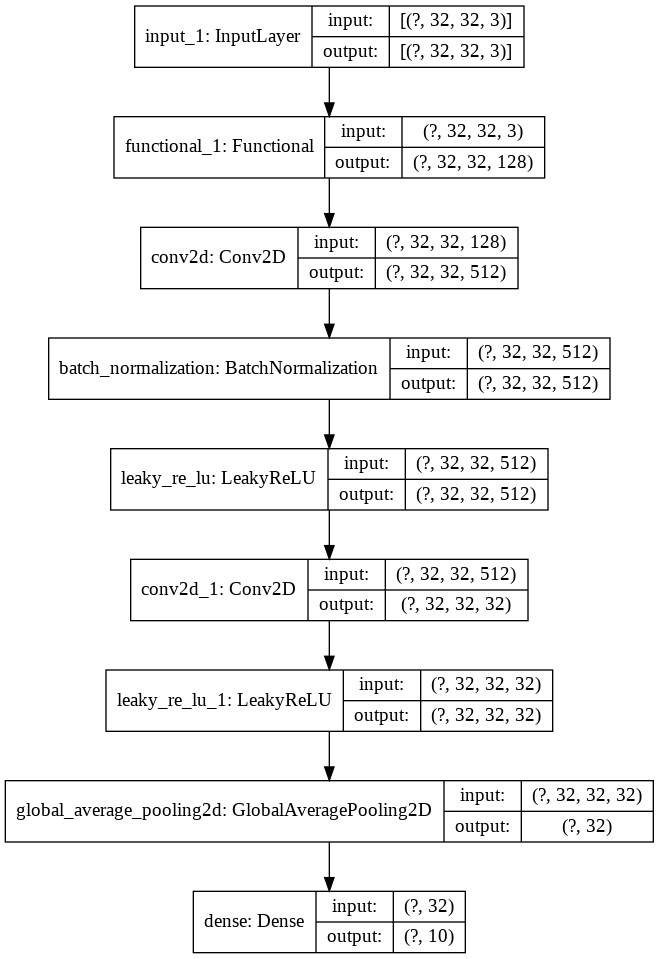

In [15]:
keras.utils.plot_model(prevBestOrganism.model, show_shapes=True)